In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

### You need to get your own license file from Gurobi's website ! It is for single machine use only ! 

In [2]:
import os
import gurobipy as gp

# Set the GRB_LICENSE_FILE environment variable to the correct license file path
os.environ["GRB_LICENSE_FILE"] = "/Users/emrekuru/Developer/Production_Planning/gurobi.lic"

In [3]:
model = gp.Model("PaintingProcessOptimization")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-11


In [4]:
# Parameters
num_parts = 10     # Number of parts
demand = {p: 50 for p in range(1, num_parts + 1)}  

color_cost = {
    'Red': 10,
    'Blue': 10,
    'Green': 10,
    'Yellow': 10,
    'Black': 10,
    "Pink": 10,
    "Purple": 10,
    }

parts_colors = {} 

group_length = 2

for i in range(1, num_parts + 1, group_length):
    color = random.choice(list(color_cost.keys()))
    while color in parts_colors.values():
        color = random.choice(list(color_cost.keys()))
        
    for j in range(group_length):
        parts_colors[i + j] = color

max_time_machine_A = (num_parts * max(demand.values())) / 2 + 50
max_time_machine_B =(num_parts * max(demand.values())) / 2 + -20

In [5]:
# Add artificial parts
artificial_part_A = num_parts + 1
artificial_part_B = num_parts + 2

# Artificial parts are dummy start points
parts_colors[artificial_part_A] = "None"  
parts_colors[artificial_part_B] = "None"

In [6]:
machines = [1,2]
# Define continuous variables for start and end times of production for each part
start_times = model.addVars(range(1, num_parts + 3), machines,  vtype=GRB.CONTINUOUS, name="start_times")
end_times = model.addVars(range(1, num_parts + 3), machines,  vtype=GRB.CONTINUOUS, name="end_times")

# Define binary variable to indicate predecessor relationship for each machine
predecessor = model.addVars(range(1, num_parts + 3), range(1, num_parts + 3), machines, vtype=GRB.BINARY, name="predecessor")

# Define binary variable for color change costs on each machine
# color_change[p, p_prime, m] = 1 if there is a color change between part p and part p_prime on machine m
color_change = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), machines, vtype=GRB.BINARY, name="color_change")

In [7]:
model.setObjective(
    quicksum(
        color_cost[parts_colors[p]] * color_change[p, q, m]
        for p in range(1, num_parts + 1)
        for q in range(1, num_parts + 1)
        for m in machines
    ),
    GRB.MINIMIZE
)

In [8]:
big_M = max_time_machine_A

# Ensure dummy part 12 is a predecessor on machine 1
model.addConstr(
    quicksum(predecessor[12, p, 1] for p in range(1, num_parts + 1)) == 1,
    name="Dummy_12_Predecessor_Machine_1"
)

# Ensure dummy part 11 is a predecessor on machine 2
model.addConstr(
    quicksum(predecessor[11, p, 2] for p in range(1, num_parts + 1)) == 1,
    name="Dummy_11_Predecessor_Machine_2"
)


# Ensure each part has at most one immediate predecessor, with exactly one part having no predecessor (the end part) per machine
for p in range(1, num_parts + 1):
        model.addConstr(
            quicksum(predecessor[q, p, m] for q in range(1, num_parts + 3) for m  in machines if q != p) == 1,
            name=f"Single_predecessor_{p}"
        )

for p in range(1, num_parts + 3):
        model.addConstr(
            quicksum(predecessor[p, q, m] for q in range(1, num_parts + 1) for m  in machines if q != p) <= 1,
            name=f"Single_predecessor_{p}"
        )
        
for p in range(1, num_parts + 1):
    for m in machines:
        model.addConstr(
            predecessor[p,p,m] == 0,
        name = "No_self_predecessor" )


# If part p is a predecessor of another part on machine m,  ensure its own predecessor is also on the same machine m
for p in range(1, num_parts + 1):
    for q in range(1, num_parts + 1):
        if p != q:
            for m in machines:
                model.addConstr(
                    quicksum(predecessor[r, p, m] for r in range(1, num_parts + 3)) >= predecessor[p, q, m],
                    name=f"Predecessor_Consistency_{p}_{q}_Machine_{m}"
                )

# Ensure color change costs are applied when there is a change in color between successive parts on the same machine
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime and parts_colors[p] != parts_colors[p_prime]:
            for m in machines:
                model.addConstr(
                    color_change[p,p_prime, m] >= predecessor[p, p_prime, m],
                    name=f"Color_Change_{p}_{p_prime}_Machine_{m}"
                )

for p in range(1, num_parts + 3):
    for m in machines:
        model.addConstr(
            start_times[p,m] <= end_times[p,m],
            name = "Time_Logic"
        )

for p in range(1, num_parts + 1):
    
    for m in machines:
        # Define the effective processing time for part p on machine m
        model.addConstr(
            (end_times[p, m] - start_times[p, m]) <= big_M * quicksum(predecessor[q, p, m] for q in range(1, num_parts + 3)),
            name=f"Active_Processing_Time_{p}_Machine_{m}"
        )
    
    # Demand fulfillment constraint
    model.addConstr(
        quicksum((end_times[p, m] - start_times[p, m]) for m in machines) == demand[p],
        name=f"Demand_Fulfillment_{p}"
    )


for p in range(1, num_parts + 3):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            for m in machines:
                model.addConstr(
                    end_times[p, m] <= start_times[p_prime, m] + big_M * (1 - predecessor[p,p_prime, m]),
                    name=f"No_Overlap_Same_Machine_{p}_{p_prime}_Machine_{m}"
                )

# Ensure no end time goes past max_time_machine_A for all parts on machine A
for p in range(1, num_parts + 1):
    model.addConstr(
        end_times[p, 1] <= max_time_machine_A + big_M * (1 - quicksum(predecessor[q, p, 1] for q in range(1, num_parts + 3))),
        name=f"Max_Time_Machine_A_{p}"
    )

# Ensure no end time goes past max_time_machine_B for all parts on machine B
for p in range(1, num_parts + 1):
    model.addConstr(
        end_times[p, 2] <= max_time_machine_B + big_M * (1 - quicksum(predecessor[q, p, 2] for q in range(1, num_parts + 3))),
        name=f"Max_Time_Machine_B_{p}"
    )



In [9]:
# Set model parameters if necessary, e.g., setting the feasibility tolerance
model.setParam("IntFeasTol", 1e-9)
model.setParam("Threads", 8) 

# Optimize the model
model.optimize()

Set parameter IntFeasTol to value 1e-09
Set parameter Threads to value 8
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 678 rows, 536 columns and 4428 nonzeros
Model fingerprint: 0x07d2ea41
Variable types: 48 continuous, 488 integer (488 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 226 rows and 296 columns
Presolve time: 0.01s
Presolved: 452 rows, 240 columns, 4180 nonzeros
Variable types: 40 continuous, 200 integer (200 binary)

Root relaxation: objective 0.000000e+00, 57 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  

In [10]:
# Check the number of quadratic constraints and non-zero quadratic terms in the objective
num_quadratic_constraints = model.getAttr("NumQConstrs")  # Number of quadratic constraints
num_quadratic_obj_terms = model.getAttr("NumQNZs")       # Number of non-zero quadratic terms in the objective

# Print the results to confirm linearity
print("Number of quadratic constraints:", num_quadratic_constraints)
print("Number of quadratic objective terms:", num_quadratic_obj_terms)

# Check if the model is MILP based on the absence of quadratic terms
is_milp = num_quadratic_constraints == 0 and num_quadratic_obj_terms == 0 and model.getAttr("IsMIP")
print("Model is MILP:", is_milp)


Number of quadratic constraints: 0
Number of quadratic objective terms: 0
Model is MILP: 1


In [11]:
predecessor

{(1, 1, 1): <gurobi.Var predecessor[1,1,1] (value 0.0)>,
 (1, 1, 2): <gurobi.Var predecessor[1,1,2] (value 0.0)>,
 (1, 2, 1): <gurobi.Var predecessor[1,2,1] (value 1.0)>,
 (1, 2, 2): <gurobi.Var predecessor[1,2,2] (value 0.0)>,
 (1, 3, 1): <gurobi.Var predecessor[1,3,1] (value 0.0)>,
 (1, 3, 2): <gurobi.Var predecessor[1,3,2] (value 0.0)>,
 (1, 4, 1): <gurobi.Var predecessor[1,4,1] (value 0.0)>,
 (1, 4, 2): <gurobi.Var predecessor[1,4,2] (value 0.0)>,
 (1, 5, 1): <gurobi.Var predecessor[1,5,1] (value 0.0)>,
 (1, 5, 2): <gurobi.Var predecessor[1,5,2] (value 0.0)>,
 (1, 6, 1): <gurobi.Var predecessor[1,6,1] (value 0.0)>,
 (1, 6, 2): <gurobi.Var predecessor[1,6,2] (value 0.0)>,
 (1, 7, 1): <gurobi.Var predecessor[1,7,1] (value 0.0)>,
 (1, 7, 2): <gurobi.Var predecessor[1,7,2] (value 0.0)>,
 (1, 8, 1): <gurobi.Var predecessor[1,8,1] (value 0.0)>,
 (1, 8, 2): <gurobi.Var predecessor[1,8,2] (value 0.0)>,
 (1, 9, 1): <gurobi.Var predecessor[1,9,1] (value 0.0)>,
 (1, 9, 2): <gurobi.Var predece

In [12]:
start_times

{(1, 1): <gurobi.Var start_times[1,1] (value 200.0)>,
 (1, 2): <gurobi.Var start_times[1,2] (value 0.0)>,
 (2, 1): <gurobi.Var start_times[2,1] (value 250.0)>,
 (2, 2): <gurobi.Var start_times[2,2] (value 0.0)>,
 (3, 1): <gurobi.Var start_times[3,1] (value 150.0)>,
 (3, 2): <gurobi.Var start_times[3,2] (value 300.0)>,
 (4, 1): <gurobi.Var start_times[4,1] (value 100.0)>,
 (4, 2): <gurobi.Var start_times[4,2] (value 0.0)>,
 (5, 1): <gurobi.Var start_times[5,1] (value 50.0)>,
 (5, 2): <gurobi.Var start_times[5,2] (value 300.0)>,
 (6, 1): <gurobi.Var start_times[6,1] (value 0.0)>,
 (6, 2): <gurobi.Var start_times[6,2] (value 0.0)>,
 (7, 1): <gurobi.Var start_times[7,1] (value 0.0)>,
 (7, 2): <gurobi.Var start_times[7,2] (value 0.0)>,
 (8, 1): <gurobi.Var start_times[8,1] (value 0.0)>,
 (8, 2): <gurobi.Var start_times[8,2] (value 50.0)>,
 (9, 1): <gurobi.Var start_times[9,1] (value 0.0)>,
 (9, 2): <gurobi.Var start_times[9,2] (value 130.0)>,
 (10, 1): <gurobi.Var start_times[10,1] (value 0

In [13]:
end_times

{(1, 1): <gurobi.Var end_times[1,1] (value 250.0)>,
 (1, 2): <gurobi.Var end_times[1,2] (value 0.0)>,
 (2, 1): <gurobi.Var end_times[2,1] (value 300.0)>,
 (2, 2): <gurobi.Var end_times[2,2] (value 0.0)>,
 (3, 1): <gurobi.Var end_times[3,1] (value 200.0)>,
 (3, 2): <gurobi.Var end_times[3,2] (value 300.0)>,
 (4, 1): <gurobi.Var end_times[4,1] (value 150.0)>,
 (4, 2): <gurobi.Var end_times[4,2] (value 0.0)>,
 (5, 1): <gurobi.Var end_times[5,1] (value 100.0)>,
 (5, 2): <gurobi.Var end_times[5,2] (value 300.0)>,
 (6, 1): <gurobi.Var end_times[6,1] (value 50.0)>,
 (6, 2): <gurobi.Var end_times[6,2] (value 0.0)>,
 (7, 1): <gurobi.Var end_times[7,1] (value 0.0)>,
 (7, 2): <gurobi.Var end_times[7,2] (value 50.0)>,
 (8, 1): <gurobi.Var end_times[8,1] (value 0.0)>,
 (8, 2): <gurobi.Var end_times[8,2] (value 100.0)>,
 (9, 1): <gurobi.Var end_times[9,1] (value 0.0)>,
 (9, 2): <gurobi.Var end_times[9,2] (value 180.0)>,
 (10, 1): <gurobi.Var end_times[10,1] (value 0.0)>,
 (10, 2): <gurobi.Var end_ti

In [14]:
# Check if the model is infeasible
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible. Computing IIS...")
    model.computeIIS()
    model.write("model.ilp")
    
    # Print the constraints that are part of the IIS
    print("\nThe following constraints are part of the IIS:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(f"{c.constrName}")

Optimal solution found:
Minimized Total Cost (Objective Value): 30.0


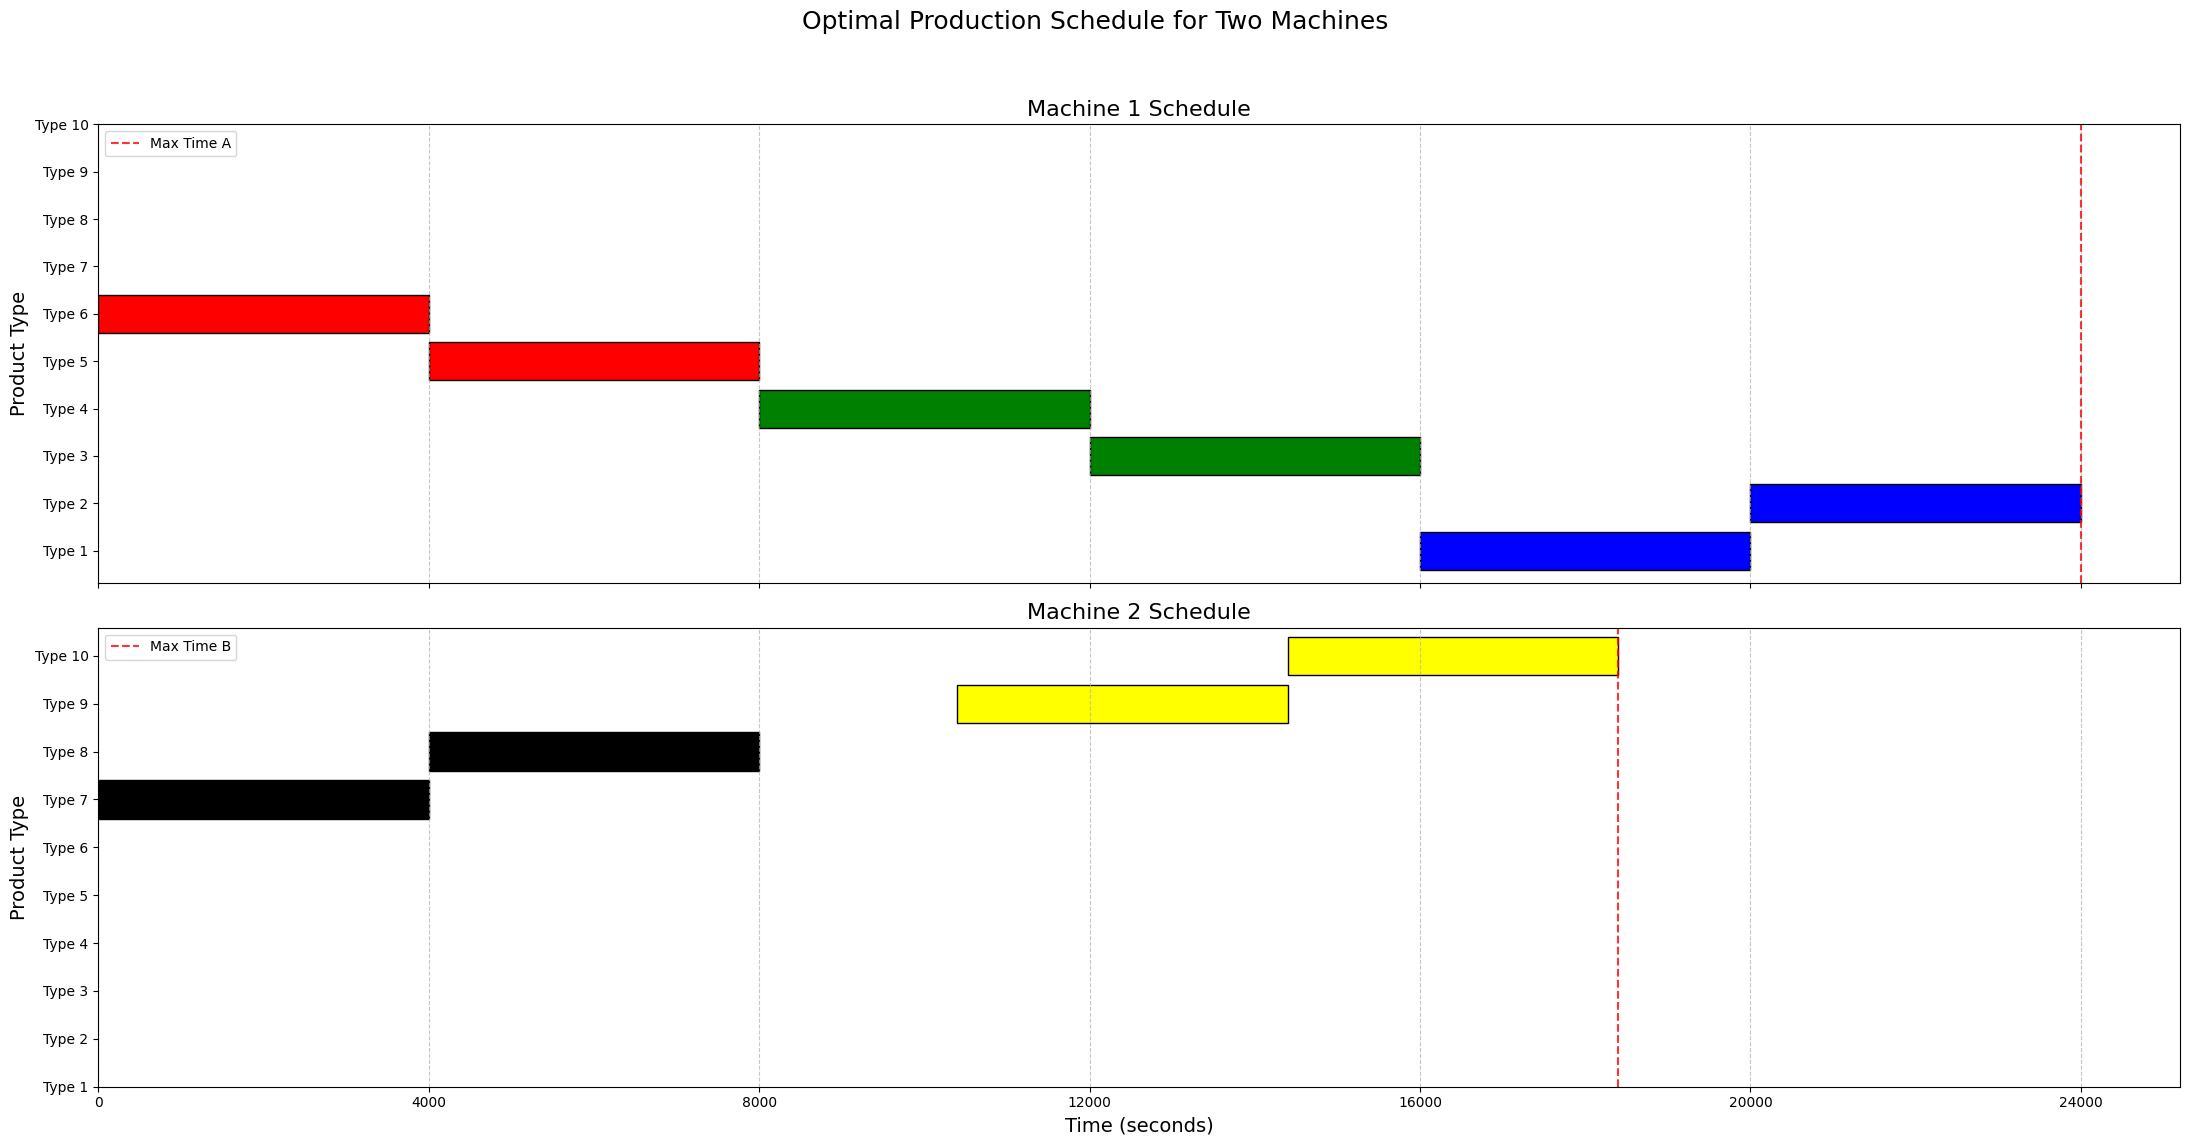

In [15]:
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    
    # Display objective function result
    minimized_cost = model.ObjVal
    print(f"Minimized Total Cost (Objective Value): {minimized_cost}")

    # Extract start and end times for each part assigned to each machine
    start_times_values = {(p, m): start_times[p, m].X for p in range(1, num_parts + 1) for m in machines}
    end_times_values = {(p, m): end_times[p, m].X for p in range(1, num_parts + 1) for m in machines}

    # Define unique break intervals for each machine (start, end, shift_amount)
    breaks = {
        1: [(0,0,0)],  # Break for Machine 1
        2: [(0,0,0)]  # Breaks for Machine 2
    }

    # Plotting the Gantt chart with two subplots for Machine 1 and Machine 2
    fig, axs = plt.subplots(2, 1, figsize=(22, 12), sharex=True)
    
    # Define color mapping for the parts
    color_map = {
        'Red': 'red',
        'Blue': 'blue',
        'Green': 'green',
        'Yellow': 'yellow',
        'Black': 'black',
        'Purple': 'purple',
        'Orange': 'orange',
        'Pink': 'pink',
    }


    # Set maximum times scaled for plotting
    max_time_A = max_time_machine_A * 80
    max_time_B = max_time_machine_B * 80

    # Iterate through each machine and process parts in a sorted order
    for m in machines:
        ax = axs[m - 1]  # Subplot for each machine (Machine 1 and Machine 2)
        cumulative_shift = 0  # Track cumulative shifts for breaks

        # Sort parts by start time for consistent plotting
        sorted_parts = sorted(
            [p for p in range(1, num_parts + 1)],
            key=lambda p: start_times[p, m].x
        )

        
        for p in sorted_parts:
            part_color = color_map[parts_colors[p]]
            start = start_times_values[(p,m)] * 80
            end = end_times_values[(p,m)] * 80
            shifted_start = start + cumulative_shift
            shifted_end = end + cumulative_shift

            if shifted_start == shifted_end:
                continue

            # Check if the part needs to be split by any breaks
            for break_start, break_end, shift_amount in breaks[m]:
                if shifted_start < break_start < shifted_end:
                    # Plot the first segment before the break
                    ax.barh(p, break_start - shifted_start, left=shifted_start, color=part_color, edgecolor='black')

                    # Shift the second segment after the break
                    shifted_start = break_end + shift_amount
                    shifted_end += shift_amount
                    ax.barh(p, end - break_end, left=shifted_start, color=part_color, edgecolor='black')

                    # Update cumulative shift for the remaining parts
                    cumulative_shift += shift_amount
                    break  # Move to the next part after handling this break
                elif shifted_start >= break_end:
                    # Entire block is after the break; apply shift
                    shifted_start += shift_amount
                    shifted_end += shift_amount

            # Plot the adjusted (shifted) part
            ax.barh(p, shifted_end - shifted_start, left=shifted_start, color=part_color, edgecolor='black')

        if m == 1:
            ax.axvline(x=max_time_A, color='red', linestyle='--', alpha=0.8, linewidth=1.5, label="Max Time A")
            ax.legend(loc='upper left')
        elif m == 2:
            ax.axvline(x=max_time_B, color='red', linestyle='--', alpha=0.8, linewidth=1.5, label="Max Time B")
            ax.legend(loc='upper left')

        # Customize each subplot
        ax.set_title(f"Machine {m} Schedule", fontsize=16)
        ax.set_ylabel("Product Type", fontsize=14)
        ax.set_yticks(range(1, num_parts + 1))
        ax.set_yticklabels([f'Type {i}' for i in range(1, num_parts + 1)])
        ax.grid(axis='x', linestyle='--', alpha=0.7)
    

    # Set common labels
    plt.xlabel("Time (seconds)", fontsize=14)
    plt.xticks(np.arange(0, (max(end_times_values.values()) + 1) * 80, 80 * max(demand.values())))  # Adjust x-tick intervals for seconds
    
    fig.suptitle("Optimal Production Schedule for Two Machines", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title space

    # Save the plot as an image file
    plt.savefig("optimal_production_schedule.png")
else:
    print("No optimal solution found.")